# Feature Engineering refering 2nd Team's

### Library import

In [2]:
import lightgbm as lgb
import numpy as np
import pandas as pd
from pprint import pprint
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
from tensorflow import keras
import tensorflow as tf
import warnings
from tqdm import tqdm, tqdm_notebook
from sklearn.model_selection import cross_val_score

from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectPercentile
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
plt.rc('font', family=fm.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()) # for Windows OS user
import datetime
import os

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import BayesianRidge
from tensorflow import keras
from scipy.stats.mstats import gmean
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import sys, warnings
if not sys.warnoptions: warnings.simplefilter("ignore")

In [4]:
trn = pd.read_csv(os.path.abspath("../input")+'/X_train.csv', encoding='cp949')
tst = pd.read_csv(os.path.abspath("../input")+'/X_test.csv', encoding='cp949')
y = pd.read_csv(os.path.abspath("../input")+'/y_train.csv', encoding='cp949')
IDtest = tst.custid.unique()
data = pd.concat([trn, tst], axis=0)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1040039 entries, 0 to 414954
Data columns (total 19 columns):
 #   Column           Non-Null Count    Dtype 
---  ------           --------------    ----- 
 0   custid           1040039 non-null  int64 
 1   sales_month      1040039 non-null  int64 
 2   sales_day        1040039 non-null  int64 
 3   sales_dayofweek  1040039 non-null  object
 4   sales_time       1040039 non-null  int64 
 5   str_nm           1040039 non-null  object
 6   goodcd           1040039 non-null  int64 
 7   brd_nm           1040039 non-null  object
 8   corner_nm        1040039 non-null  object
 9   pc_nm            1040039 non-null  object
 10  part_nm          1040039 non-null  object
 11  team_nm          1040039 non-null  object
 12  buyer_nm         1040039 non-null  object
 13  import_flg       1040039 non-null  int64 
 14  tot_amt          1040039 non-null  int64 
 15  dis_amt          1040039 non-null  int64 
 16  net_amt          1040039 non-null  in

### 날짜 데이터 다루기

In [6]:
# 년 정리
data['sales_year']=data['sales_month'].apply(lambda x: 2018 if x >12 else 2017)

# 월 정리
data['sales_month'] = data['sales_month'].apply(lambda x: x-12 if x >12 else x)

# 주말
data['weekend'] = data['sales_dayofweek'].apply(lambda x: 1 if (x=='토' or x=='일') else 0)

In [8]:
# 데이터 타입 변경
data['sales_year']=data['sales_year'].astype('str')
data['sales_month']=data['sales_month'].astype('str')
data['sales_day']=data['sales_day'].astype('str')

In [9]:
# 주어진 날짜데이터를 datetime 형식으로 바꾸기위한 준비
data['date_time']=data['sales_year']+'-'+data['sales_month']+'-'+data['sales_day']

# datetime 형식으로 바꾸기
data['date_time'] = pd.to_datetime(data['date_time'])

In [10]:
# 새로만든 데이터의 타입을 정수로 변경 (분석의 용이성)
data['sales_year']=data['sales_year'].astype('int')
data['sales_month']=data['sales_month'].astype('int')
data['sales_day']=data['sales_day'].astype('int')

In [49]:
a=data.groupby(['custid'])['date_time'].diff()

In [50]:
a=a.reset_index().set_index(data.custid)

In [51]:
a=a.reset_index()

In [52]:
a.set_index('index',inplace=True)

In [53]:
aa = a.groupby('custid')['date_time'].sum().reset_index()

In [54]:
# custid 별로 방문일수를 표시한다. (독자적인 column단위로 다룸)
display(aa)

,custid,date_time
0,0,95 days
1,2,306 days
2,3,419 days
3,4,4 days
4,5,232 days
...,...,...
35962,49988,86 days
35963,49990,85 days
35964,49992,34 days
35965,49993,130 days


In [57]:
aa['datetime'] = aa['date_time'].astype('str')

In [58]:
aa['datetime'] = aa['datetime'].apply(lambda x: x.split(' ')[0])

In [59]:
aa['datetime'] = aa['datetime'].astype('int')

In [60]:
time_mean = aa.groupby('custid')['datetime'].mean().reset_index()
time_mean

,custid,datetime
0,0,95
1,2,306
2,3,419
3,4,4
4,5,232
...,...,...
35962,49988,86
35963,49990,85
35964,49992,34
35965,49993,130


### word2vec

In [62]:
import random

trn2=trn.reset_index().drop('index',axis=1).copy()
trn2=trn2.reset_index()
trn2['goodcd']=trn2['goodcd'].astype('str')
train_data=list(trn2.groupby('custid')['goodcd'].unique())

#display(train_data)

[array(['2116050008000', '4125440008000', '2116052008000', '4106430119900',
        '2139141008000', '4300381019900', '6315960019900'], dtype=object),
 array(['4301000017000', '4309200019900', '4522862046000', '4400213022910',
        '2116052008000', '4134870003200', '4502161930200'], dtype=object),
 array(['4226470013074', '2700000000000', '4414070026270', '4414070026000',
        '4417232028400', '4400591020000', '6311162019900', '4109350003200',
        '4405620111000', '4550900939000', '4300810019971', '4100615200100',
        '4234960014400', '4309141016400', '4556360043077', '2139140008300',
        '4400492028400', '4420400029970', '4202285010000', '4406050025000',
        '4423220025000', '4400502028400'], dtype=object),
 array(['4125440008000', '4221340110000', '4230670013074', '4206071013074'],
       dtype=object),
 array(['6315970019900', '6300010019900', '4409230020400', '4400202022000',
        '4400040020030', '4217070010000', '4408220027900', '2116052008000',
        '

In [67]:
# goodcd가 너무 많으니까 랜덤으로 뽑은거
# 트레인데이터에 먼저 적용
def oversample(x, n):
    lst = []
    for i in x:
        tmp = []
        for j in range(n):
            random.shuffle(i)
            tmp += list(i)
            lst.append(tmp)
    return lst

In [69]:
# word2vec 적용전 input 데이터 준비
w2v_input = oversample(train_data, 5)

In [70]:
from gensim.models import word2vec
# word2vec 알고리즘 적용
w2v = word2vec.Word2Vec(sentences = w2v_input, size = 100, window = 3, min_count = 1, sg = 1)

In [71]:
train_mean_vector = []
for words in tqdm(train_data):
    tmp = np.zeros(100)
    cnt = 0
    for word in words:
        try:
            tmp += w2v[word]
            cnt += 1
        except:
            pass
    tmp /= cnt
    train_mean_vector.append(tmp)
train_mean_vector = np.array(train_mean_vector)

100%|██████████████████████████████████████████████████████████████████████████| 21587/21587 [00:06<00:00, 3511.18it/s]


In [72]:
# 최종적으로 사용할 train_data 생성
train_mean_vector = pd.DataFrame(train_mean_vector)
display(train_mean_vector.head())
display(train_mean_vector.shape)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.041928,0.010972,0.215726,0.055502,-0.080552,0.051122,0.126212,0.045050,-0.060350,-0.265742,...,0.315908,0.186348,-0.137314,0.023652,-0.071803,-0.023077,0.015955,0.067195,0.123257,0.017069
1,0.162830,-0.120862,0.022160,-0.003893,-0.145576,-0.055790,0.328136,0.201738,0.032353,-0.336207,...,0.508378,0.116229,-0.165716,-0.097732,-0.213580,-0.238919,0.138185,0.029009,-0.020097,-0.129550
2,-0.020324,0.099985,0.272016,-0.127368,-0.144017,0.066207,0.215798,-0.120980,0.001096,-0.171538,...,0.189670,0.041655,0.041977,0.170166,-0.128733,0.137020,0.347108,0.067634,-0.038666,0.182087
3,0.102942,-0.054811,0.206863,0.076473,-0.029777,-0.037872,0.378434,-0.023466,0.008127,-0.071225,...,-0.030774,0.422866,-0.077372,-0.245819,-0.099829,-0.103595,0.228107,-0.118550,0.429022,-0.331686
4,-0.055265,-0.058015,0.336801,0.158505,-0.152858,-0.061427,0.138124,0.012503,-0.034167,-0.253228,...,0.240199,0.057249,-0.026505,0.097697,-0.138563,0.078147,0.075115,0.143055,0.022794,0.030847


(21587, 100)

In [73]:
# 테스트데이터에 동일하게 적용
tst2=tst.reset_index().drop('index',axis=1).copy()
tst2=tst2.reset_index()
tst2['goodcd']=tst2['goodcd'].astype('str')
test_data=list(tst2.groupby('custid')['goodcd'].unique())

In [74]:
test_mean_vector = []
for words in tqdm(test_data):
    tmp = np.zeros(100)
    cnt = 0
    for word in words:
        try:
            tmp += w2v[word]
            cnt += 1
        except:
            pass
    tmp /= cnt
    test_mean_vector.append(tmp)
test_mean_vector = np.array(test_mean_vector)

100%|██████████████████████████████████████████████████████████████████████████| 14380/14380 [00:03<00:00, 4412.49it/s]


In [75]:
test_mean_vector = pd.DataFrame(test_mean_vector)
display(test_mean_vector.head())
display(test_mean_vector.shape)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.132254,0.067233,0.084273,0.099049,-0.092805,-0.070556,0.162002,-0.019461,-0.234714,-0.215142,...,0.444342,0.014752,-0.168588,-0.010406,-0.157667,0.112811,0.047409,0.072320,0.115210,0.150447
1,-0.026987,0.059592,0.143867,0.095296,-0.134756,0.058088,0.272249,0.014998,-0.082229,-0.265549,...,0.298328,0.144448,-0.022424,0.071430,-0.131902,-0.028585,-0.037755,0.016143,0.086632,0.058499
2,0.039943,0.017807,0.023924,0.133804,-0.191414,-0.040740,0.069532,-0.140159,0.041357,0.010289,...,0.262527,-0.010721,-0.125940,0.054630,-0.135784,0.157583,0.156054,0.078817,0.130739,-0.159531
3,0.078112,-0.044465,0.103774,0.189552,-0.133972,0.096646,0.047771,0.026663,-0.065039,-0.151448,...,0.230590,0.071522,-0.125335,-0.176496,-0.003760,-0.037680,-0.109866,0.056316,0.126365,0.134055
4,0.003506,-0.037557,0.147906,0.013205,-0.194745,0.019617,0.064422,-0.089123,-0.037105,-0.026708,...,0.142403,0.131548,-0.087861,0.014829,-0.097195,0.031313,-0.035392,-0.047617,0.261103,-0.035998


(14380, 100)

In [86]:
# 분석에 용이하도록 goodcd의 train data, test data 병합
goodcd_w2v = pd.concat([train_mean_vector, test_mean_vector], axis=0)
goodcd_w2v = goodcd_w2v.add_prefix("goodcd_")
display(goodcd_w2v.head())
display(goodcd_w2v.shape)

,goodcd_0,goodcd_1,goodcd_2,goodcd_3,goodcd_4,goodcd_5,goodcd_6,goodcd_7,goodcd_8,goodcd_9,...,goodcd_90,goodcd_91,goodcd_92,goodcd_93,goodcd_94,goodcd_95,goodcd_96,goodcd_97,goodcd_98,goodcd_99
0,-0.041928,0.010972,0.215726,0.055502,-0.080552,0.051122,0.126212,0.045050,-0.060350,-0.265742,...,0.315908,0.186348,-0.137314,0.023652,-0.071803,-0.023077,0.015955,0.067195,0.123257,0.017069
1,0.162830,-0.120862,0.022160,-0.003893,-0.145576,-0.055790,0.328136,0.201738,0.032353,-0.336207,...,0.508378,0.116229,-0.165716,-0.097732,-0.213580,-0.238919,0.138185,0.029009,-0.020097,-0.129550
2,-0.020324,0.099985,0.272016,-0.127368,-0.144017,0.066207,0.215798,-0.120980,0.001096,-0.171538,...,0.189670,0.041655,0.041977,0.170166,-0.128733,0.137020,0.347108,0.067634,-0.038666,0.182087
3,0.102942,-0.054811,0.206863,0.076473,-0.029777,-0.037872,0.378434,-0.023466,0.008127,-0.071225,...,-0.030774,0.422866,-0.077372,-0.245819,-0.099829,-0.103595,0.228107,-0.118550,0.429022,-0.331686
4,-0.055265,-0.058015,0.336801,0.158505,-0.152858,-0.061427,0.138124,0.012503,-0.034167,-0.253228,...,0.240199,0.057249,-0.026505,0.097697,-0.138563,0.078147,0.075115,0.143055,0.022794,0.030847


(35967, 100)

- 이후에 범주형 피쳐들은 내가 했던 방식을 사용하겠다.

### sales_time column extraction

In [76]:
# sales time - 아침/ 낮/ 밤 구매 나누기
data['sales_time'] = data['sales_time'].apply(lambda x: int(str(x)[:2]) if len(str(x)) == 4 else int(str(x)[:1]))
data['sales_time_cat'] = data['sales_time'].apply(lambda x: 'mo_sales' if (9 <= x <= 12) else ('af_sales' if (13 <= x <= 18) else 'knt_sales'))

In [77]:
# dis_amt - 할인율 특성 추가
data['dis_rate'] = data['dis_amt']/data['tot_amt']

In [78]:
# 퇴근전/후 구매 빈도, 비율
def get_off_work(x):
    if 9<=x<=17:
        return('bf_work')
    else:
        return('af_work')
data['sales_type'] = data['sales_time'].map(get_off_work)

시간별 구매 횟수

In [79]:
# 시간당 구매빈도
freq_per_time = pd.pivot_table(index='custid',columns='sales_time',
                               values='tot_amt',aggfunc=np.size, 
                               fill_value=0, 
                               data=data.query("tot_amt>0")[['custid','sales_time','tot_amt']]).reset_index()

In [80]:
# 구매 타입
sales_type = pd.pivot_table(index='custid',columns='sales_type',
                            values='tot_amt',aggfunc=np.size, 
                            fill_value=0,data = data.query('tot_amt>0')[['custid','sales_type','tot_amt']]).reset_index()

In [81]:
freq_per_time.columns=['custid', '1_stf', '9_stf', "10_stf", '11_stf', 
                       '12_stf', '13_stf', '14_stf', '15_stf', '16_stf', 
                       '17_stf', '18_stf', '19_stf', '20_stf', '21_stf', '22_stf']

In [87]:
features = pd.merge(freq_per_time, sales_type, on = 'custid')

In [89]:
features

,custid,1_stf,9_stf,10_stf,11_stf,12_stf,13_stf,14_stf,15_stf,16_stf,17_stf,18_stf,19_stf,20_stf,21_stf,22_stf,af_work,bf_work
0,0,0,0,0,0,2,0,0,0,0,0,4,5,0,0,0,9,2
1,2,0,0,1,1,0,1,1,0,1,1,1,2,0,0,0,3,6
2,3,0,0,0,2,3,2,3,0,0,5,11,2,0,0,0,13,15
3,4,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,4
4,5,0,0,0,8,1,2,0,1,3,5,6,6,0,0,0,12,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35962,49988,0,0,0,0,3,0,0,0,0,0,1,0,0,0,0,1,3
35963,49990,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
35964,49992,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,1
35965,49993,0,0,0,0,0,0,0,0,1,2,1,0,0,0,0,1,3


In [90]:
features = pd.merge(features, time_mean, on = 'custid')

In [91]:
def floor_transfer_a(x) :
    return  {
        "무역점" : 0,
        "본점" : 1,
        "신촌점" : 0,
        "천호점" : 1
    }.get(x)

def floor_transfer_m(x) :  
    return  {
        "무역점" : 1/10*13,
        "본점" : 1/6*13,
        "신촌점" : 1/11*13,
        "천호점" : 1
    }.get(x)
data['floor'] = (data.str_nm.apply(floor_transfer_a))*data.str_nm.apply(floor_transfer_m).astype(int)

In [92]:
features = pd.merge(features, data.groupby('custid')['floor'].mean().reset_index(), on = 'custid')

In [93]:
# 일과시간 전후 비율
features['af_work_rate'] = features['af_work']/(features['af_work'] + features['bf_work'])
features['bf_work_rate'] = features['bf_work']/(features['af_work'] + features['bf_work'])

In [94]:
# 아침구매/ 낮구매/ 밤구매
freq_sales_cat = pd.pivot_table(index='custid',columns='sales_time_cat',values='tot_amt',aggfunc=np.size, fill_value=0, data=data.query("tot_amt>0")[['custid','sales_time_cat','tot_amt']]).reset_index()
features = pd.merge(features, freq_sales_cat,on='custid')

In [95]:
# 반품 빈도
refund_freq=data.query('tot_amt<0').groupby('custid')['sales_day'].count().reset_index()
features = pd.merge(features, refund_freq, left_on = 'custid',right_on='custid',how='left')
features.rename(columns = {'sales_day': 'refund_freq'},inplace=True)
features.fillna(0,inplace=True)

In [96]:
# 구매 빈도
sales_freq=data.query('tot_amt>0').groupby('custid')['sales_day'].count().reset_index()
features = pd.merge(features, sales_freq, left_on = 'custid',right_on='custid',how='left')
features.rename(columns = {'sales_day': 'sales_freq'},inplace=True)

In [97]:
# 구매 빈도 특성 추가
all_freq=data.groupby('custid')['sales_day'].count().reset_index()
features = pd.merge(features, all_freq,  left_on = 'custid',right_on='custid',how='left')
features.rename(columns = {'sales_day': 'all_freq'},inplace=True)

In [98]:
features['refund_sales_rate']=features['refund_freq']/features['sales_freq']
features['refund_all_rate'] = features['refund_freq']/features['all_freq']

방문한 날짜의 갯수

In [99]:
data_aaa=data.groupby(['custid','sales_month','sales_day'])['sales_dayofweek'].count().reset_index()

In [100]:
data_aaa.sales_dayofweek=1
data_aaa=data_aaa.groupby('custid')['sales_dayofweek'].sum().reset_index()
features = pd.merge(features, data_aaa, on = 'custid')
features['sales_freq_mean']=features['sales_freq']/features['sales_dayofweek']

평일에 방문하는 평균 시간

In [101]:
normal_days=data[data.weekend==0].groupby('custid')['sales_time'].mean().reset_index()
features = pd.merge(features, normal_days, how='left',on = 'custid')
visit=data[data.weekend==0].groupby('custid')['sales_time'].agg([('sales_time_mod', lambda x: x.value_counts().index[0])]).reset_index()
features = pd.merge(features, visit, how='left',on = 'custid')

주말에 방문하는 평균 시간

In [102]:
satsun=data[data.weekend==1].groupby('custid')['sales_time'].mean().reset_index()
features = pd.merge(features, satsun, how='left',on = 'custid')
visit=data[data.weekend==1].groupby('custid')['sales_time'].agg([('sales_time_mod', lambda x: x.value_counts().index[0])]).reset_index()
features = pd.merge(features, visit, how='left',on = 'custid')

In [103]:
# 수입상품 관련 열
sales_import=data.groupby('custid')['import_flg'].agg('sum').reset_index()
features = pd.merge(features, sales_import, on = 'custid')

features.rename(columns = {'import_flg': 'sales_import'},inplace=True)

In [104]:
# 수입상품 구매 빈도 추가
features['import_rate']=features['sales_import']/features['sales_freq']

In [105]:
# 수입상품 환불 빈도 추가
features['import_refund_rate']=features['sales_import']/(features['refund_freq']+1)

In [106]:
# 계절별 구매 빈도 추가
def f1(x):
    if 3 <= x <= 5 :
        return('spring_sales')
    elif 6 <= x <= 8 :
        return('summer_sales')
    elif 9 <= x <= 11 :
        return('fall_sales')
    else :
        return('winter_sales')    

In [107]:
data['season_sales']=data['sales_month'].apply(f1)

In [108]:
season = pd.pivot_table(data, index='custid', columns='season_sales', values='tot_amt', 
                   aggfunc=np.size, fill_value=0).reset_index()
features = pd.merge(features, season, how='left',on = 'custid')

In [109]:
#계절별 구매만 빈도
season_sales_freq = pd.pivot_table(index='custid',columns='season_sales',values='tot_amt',aggfunc=np.size, fill_value=0, data=data.query("tot_amt>0")[['custid','season_sales','tot_amt']]).reset_index()
features = pd.merge(features, season_sales_freq, how='left',on = 'custid')

In [110]:
#계절별 환불만 빈도
season_refund_freq = pd.pivot_table(index='custid',columns='season_sales',values='tot_amt',aggfunc=np.size, fill_value=0, data=data.query("tot_amt<0")[['custid','season_sales','tot_amt']]).reset_index()
features = pd.merge(features, season_refund_freq, how='left',on = 'custid')
features.fillna(0,inplace=True)

In [111]:
features['sales_fall_rate']=features.fall_sales_x/(features.fall_sales_x+features.spring_sales_x+features.summer_sales_x+features.winter_sales_x)
features['sales_spring_rate']=features.spring_sales_x/(features.fall_sales_x+features.spring_sales_x+features.summer_sales_x+features.winter_sales_x)
features['sales_summer_rate']=features.summer_sales_x/(features.fall_sales_x+features.spring_sales_x+features.summer_sales_x+features.winter_sales_x)
features['sales_winter_rate']=features.winter_sales_x/(features.fall_sales_x+features.spring_sales_x+features.summer_sales_x+features.winter_sales_x)
features['refund_fall_rate']=features.fall_sales_y/(features.fall_sales_y+features.spring_sales_y+features.summer_sales_y+features.winter_sales_y)
features['refund_fall_rate']=features.fall_sales_y/(features.fall_sales_y+features.spring_sales_y+features.summer_sales_y+features.winter_sales_y)
features['refund_spring_rate']=features.spring_sales_y/(features.fall_sales_y+features.spring_sales_y+features.summer_sales_y+features.winter_sales_y)
features['refund_summer_rate']=features.summer_sales_y/(features.fall_sales_y+features.spring_sales_y+features.summer_sales_y+features.winter_sales_y)
features['refund_winter_rate']=features.winter_sales_y/(features.fall_sales_y+features.spring_sales_y+features.summer_sales_y+features.winter_sales_y)
features['all_fall_rate']=features.fall_sales/(features.fall_sales+features.spring_sales+features.summer_sales+features.winter_sales)
features['all_spring_rate']=features.spring_sales/(features.fall_sales+features.spring_sales+features.summer_sales+features.winter_sales)
features['all_summer_rate']=features.summer_sales/(features.fall_sales+features.spring_sales+features.summer_sales+features.winter_sales)
features['all_winter_rate']=features.winter_sales/(features.fall_sales+features.spring_sales+features.summer_sales+features.winter_sales)
# 주말 구매 비율
features['wd_sales_rate'] = (data.groupby('custid')['weekend'].sum().reset_index()['weekend']/features['sales_freq'])*100

월별 구매액의 합, 평균

In [112]:
month_sales_mn=data.groupby(['custid','sales_month'])['net_amt'].mean().unstack().fillna(0)

month_sales_mn.columns = ['mon_sale_mn'+ str(column) for column in month_sales_mn.columns]
month_sales_mn = month_sales_mn.reset_index()

month_sales_sm=data.groupby(['custid','sales_month'])['net_amt'].sum().unstack().fillna(0)

month_sales_sm.columns = ['mon_sale_sm'+ str(column) for column in month_sales_sm.columns]
month_sales_sm = month_sales_sm.reset_index()

features = pd.merge(features, month_sales_sm, how='left',on = 'custid')
features = pd.merge(features, month_sales_mn, how='left',on = 'custid')

# 구매 월 평균
features['month_mean'] = data.groupby('custid')['sales_month'].mean().reset_index()['sales_month']

In [113]:
# 자주 가는 월 - 원래 자주가는 
#f = pd.pivot_table(data, index='custid', columns='sales_month', values='tot_amt', 
#                   aggfunc=np.size, fill_value=0).reset_index()
f=pd.pivot_table(data[data.tot_amt>0], index='custid', columns='sales_month', values='tot_amt', 
                   aggfunc=np.size, fill_value=0).reset_index()

In [114]:
f.columns=['custid', '1_mmff', '2_mmff', '3_mmff', '4_mmff', 
           '5_mmff', '6_mmff', '7_mmff', '8_mmff', '9_mmff', 
           '10_mmff', '11_mmff', '12_mmff']

In [115]:
features = pd.merge(features, f, how='left',on = 'custid')

금액 관리

In [116]:
refund_net_sum=data[data.net_amt<0].groupby('custid')['net_amt'].sum().reset_index()
features = pd.merge(features, refund_net_sum, how='left',on = 'custid')

net_saels_all=data.groupby('custid')['net_amt'].agg([('tot_sales_all','sum'),('mean_amt_all','mean')])
features = pd.merge(features, net_saels_all, how='left',on = 'custid').fillna(0)

net_sales_0_all=data[data.net_amt>0].groupby('custid')['net_amt'].agg([('tot_sales','sum'),('max_sales_amt','max'),('min_sales_amt','min'),('mean_sales_amt','mean')])
features = pd.merge(features, net_sales_0_all, how='left',on = 'custid').fillna(0)

net_refund_all=data[data.net_amt<0].groupby('custid')['net_amt'].agg([('tot_refund','sum'),('max_refund_amt','max'),('min_refund_amt','min'),('mean_refund_amt','mean')])
features = pd.merge(features, net_refund_all, how='left',on = 'custid').fillna(0)

features[['mean_amt_all','mean_sales_amt','mean_refund_amt']] =round(features[['mean_amt_all','mean_sales_amt','mean_refund_amt']],2)

features['tot_sales_freq_mean']=features['tot_sales']/features['sales_dayofweek']

In [117]:
# 총 할인금액
features['tot_dis_amt'] = data.groupby('custid')['dis_amt'].sum().reset_index()['dis_amt']

# 최대, 평균 할인율
features['max_dis'] = data.groupby('custid')['dis_rate'].max().reset_index()['dis_rate']
features['mean_dis'] = data.groupby('custid')['dis_rate'].mean().reset_index()['dis_rate']

# 할인 받은 빈도, 비율
dis_rate=data.query("dis_rate>0").groupby('custid')['dis_rate'].count().reset_index()
features = pd.merge(features, dis_rate, how='left',on='custid').fillna(0)
features.rename(columns = {'dis_rate': 'dis_freq'},inplace=True)

features['dis_freq_rate'] = features['dis_freq']/features['sales_freq']

# 할부 빈도, 비율/ 평균 할부개월
inst_ft = data.query("inst_mon != 1").groupby('custid')['inst_mon'].agg([('inst_freq','count'),('inst_avg','mean'),('inst_max','max')])
features = pd.merge(features, inst_ft, how='left',on = 'custid').fillna(0)
features['inst_freq_rate'] = features['inst_freq']/features['sales_freq']
features['inst_freq_all_rate'] = features['inst_freq']/features['all_freq']

# 할부 총 달
inst_ft_sum = data.groupby('custid')['inst_mon'].agg([('inst_sum','sum')])
features = pd.merge(features, inst_ft_sum, how='left',on = 'custid').fillna(0)

features['tot_inst_amt']=features['tot_sales']/features['inst_sum']

# 할부 총 달
sales_noinst = data.groupby('custid')['inst_fee'].agg([('inst_fee_sum','sum')])
features = pd.merge(features, sales_noinst, how='left',on = 'custid').fillna(0)

In [118]:
# 자주가는 지점이 어딘지 원핫인코딩 한 것
data['str_nm'] = data['str_nm'].apply(lambda x: 'mu' if x=='무역점' else('bon' if x=='본점' else('cheon' if x=='천호점' else 'sin')))
f = data.groupby(['custid','str_nm'])['str_nm'].agg([('str_freq','count')]).reset_index()

lst = []
for i in tqdm_notebook(f['custid'].unique()) : 
    f2 = f.query("custid == @i")
    lst.append(f2.sort_values(by='str_freq',ascending=False)['str_nm'].iloc[0])

features['str_freq'] = lst

features = pd.get_dummies(features, 'str_freq')

아이디별 매장별 몇번씩 갔는지

In [119]:
str_freq_all=data.groupby(['custid','str_nm'])['str_nm'].count().unstack().fillna(0)

str_freq_all.columns = ['store_'+ str(column) for column in str_freq_all.columns]
str_freq_all = str_freq_all.reset_index()

features = pd.merge(features, str_freq_all, how='left',on = 'custid')

매장별로 얼마나 구매를 하였는지 총 구매액

In [120]:
str_sale_sum=data[data.net_amt>0].groupby(['custid','str_nm'])['net_amt'].sum().unstack().fillna(0)

str_sale_sum.columns = ['str_sales'+ str(column) for column in str_sale_sum.columns]
str_sale_sum = str_sale_sum.reset_index()

features = pd.merge(features, str_sale_sum, how='left',on = 'custid')

str_refund_sum=data[data.net_amt<0].groupby(['custid','str_nm'])['net_amt'].sum().unstack().fillna(0)

str_refund_sum.columns = ['str_refund'+ str(column) for column in str_refund_sum.columns]
str_refund_sum = str_refund_sum.reset_index()

features = pd.merge(features, str_refund_sum, how='left',on = 'custid')

In [121]:
# 선호 브랜드
df = pd.merge(trn, y, on='custid')

twn_prefer_brd = df.query("age>=20 & age<30").brd_nm.value_counts().index[1:11].tolist()
thr_prefer_brd = df.query("age>=30 & age<40").brd_nm.value_counts().index[1:11].tolist()
for_prefer_brd = df.query("age>=40 & age<50").brd_nm.value_counts().index[1:11].tolist()
fiv_prefer_brd = df.query("age>=50 & age<60").brd_nm.value_counts().index[1:11].tolist()
six_prefer_brd = df.query("age>=60").brd_nm.value_counts().index[1:11].tolist()

In [122]:
def map_twn_brd(x):
    if x == twn_prefer_brd[0]:
        x=10
    elif x == twn_prefer_brd[1]:
        x=9
    elif x == twn_prefer_brd[2]:
        x=8
    elif x == twn_prefer_brd[3]:
        x=7
    elif x == twn_prefer_brd[4]:
        x=6
    elif x == twn_prefer_brd[5]:
        x=5
    elif x == twn_prefer_brd[6]:
        x=4
    elif x == twn_prefer_brd[7]:
        x=3
    elif x == twn_prefer_brd[8]:
        x=2
    elif x == twn_prefer_brd[9]:
        x=1
    else:
        x=0
    return x

In [123]:
def map_thr_brd(x):
    if x == thr_prefer_brd[0]:
        x=10
    elif x == thr_prefer_brd[1]:
        x=9
    elif x == thr_prefer_brd[2]:
        x=8
    elif x == thr_prefer_brd[3]:
        x=7
    elif x == thr_prefer_brd[4]:
        x=6
    elif x == thr_prefer_brd[5]:
        x=5
    elif x == thr_prefer_brd[6]:
        x=4
    elif x == thr_prefer_brd[7]:
        x=3
    elif x == thr_prefer_brd[8]:
        x=2
    elif x == thr_prefer_brd[9]:
        x=1
    else:
        x=0
    return x

In [124]:
def map_for_brd(x):
    if x == for_prefer_brd[0]:
        x=10
    elif x == for_prefer_brd[1]:
        x=9
    elif x == for_prefer_brd[2]:
        x=8
    elif x == for_prefer_brd[3]:
        x=7
    elif x == for_prefer_brd[4]:
        x=6
    elif x == for_prefer_brd[5]:
        x=5
    elif x == for_prefer_brd[6]:
        x=4
    elif x == for_prefer_brd[7]:
        x=3
    elif x == for_prefer_brd[8]:
        x=2
    elif x == for_prefer_brd[9]:
        x=1
    else:
        x=0
    return x

In [125]:
def map_fiv_brd(x):
    if x == fiv_prefer_brd[0]:
        x=10
    elif x == fiv_prefer_brd[1]:
        x=9
    elif x == fiv_prefer_brd[2]:
        x=8
    elif x == fiv_prefer_brd[3]:
        x=7
    elif x == fiv_prefer_brd[4]:
        x=6
    elif x == fiv_prefer_brd[5]:
        x=5
    elif x == fiv_prefer_brd[6]:
        x=4
    elif x == fiv_prefer_brd[7]:
        x=3
    elif x == fiv_prefer_brd[8]:
        x=2
    elif x == fiv_prefer_brd[9]:
        x=1
    else:
        x=0
    return x

In [126]:
def map_six_brd(x):
    if x == six_prefer_brd[0]:
        x=10
    elif x == six_prefer_brd[1]:
        x=9
    elif x == six_prefer_brd[2]:
        x=8
    elif x == six_prefer_brd[3]:
        x=7
    elif x == six_prefer_brd[4]:
        x=6
    elif x == six_prefer_brd[5]:
        x=5
    elif x == six_prefer_brd[6]:
        x=4
    elif x == six_prefer_brd[7]:
        x=3
    elif x == six_prefer_brd[8]:
        x=2
    elif x == six_prefer_brd[9]:
        x=1
    else:
        x=0
    return x

In [127]:
data['twn_brd_point'] = data['brd_nm'].apply(map_twn_brd)
data['thr_brd_point'] = data['brd_nm'].apply(map_thr_brd)
data['for_brd_point'] = data['brd_nm'].apply(map_for_brd)
data['fiv_brd_point'] = data['brd_nm'].apply(map_fiv_brd)
data['six_brd_point'] = data['brd_nm'].apply(map_six_brd)

In [128]:
twn_brd_point=data.groupby('custid')['twn_brd_point'].mean().reset_index()
thr_brd_point=data.groupby('custid')['thr_brd_point'].mean().reset_index()
for_brd_point=data.groupby('custid')['for_brd_point'].mean().reset_index()
fiv_brd_point=data.groupby('custid')['fiv_brd_point'].mean().reset_index()
six_brd_point=data.groupby('custid')['six_brd_point'].mean().reset_index()

In [129]:
features = pd.merge(features, twn_brd_point, how='left',on='custid')
features = pd.merge(features, thr_brd_point, how='left',on='custid')
features = pd.merge(features, for_brd_point, how='left',on='custid')
features = pd.merge(features, fiv_brd_point, how='left',on='custid')
features = pd.merge(features, six_brd_point, how='left',on='custid')

In [130]:
data['buyer_nm'] = data['buyer_nm'].str.replace('행사장.*','행사장')
data['buyer_nm'] = data['buyer_nm'].str.replace('피혁A','피혁')
data['buyer_nm'] = data['buyer_nm'].str.replace('피혁B','피혁')

data['buyer_nm'] = data['buyer_nm'].map({'화장품':'a', '수입명품':'b', '캐릭터캐주얼':'c', '트래디셔널캐주얼':'d', '유아동복':'e', '니트단품':'f', '영캐주얼':'g',
       '엘레강스캐주얼':'h', '가전':'i', '섬유':'j', '장신구':'k', '조리욕실':'l', '스포츠':'m', '침구수예':'n', '피혁':'o', '일반식품':'p',
       '유니캐주얼':'q', '정장셔츠':'r', '디자이너부띠끄':'s', '문화완구':'t', '타운모피':'u', '조리식품':'v', '기타바이어':'w',
       '도자기크리스탈':'x', '가구':'y', '생활용품':'z', '행사장':'aa', '청과곡물':'bb', '점외':'cc'})

buyer = pd.pivot_table(index='custid',columns='buyer_nm',values='tot_amt',aggfunc=np.size,fill_value=0,data=data.query("tot_amt>0")[['custid','buyer_nm','tot_amt']]).reset_index()
features = pd.merge(features, buyer, on='custid')

In [131]:
#구매상품군 다양성
n = data.part_nm.nunique()
f = data.groupby('custid')['part_nm'].agg([('part_unique', lambda x: len(x.unique()) / n)]).reset_index()
features = pd.merge(features, f, on='custid')

In [132]:
#브랜드 다양성
n=data.brd_nm.nunique()
f = data.groupby('custid')['brd_nm'].agg([('brd_unique', lambda x: len(x.unique()) / n)]).reset_index()
features = pd.merge(features, f, on='custid')

In [133]:
#매장 이용 다양성
n = 4
f = data.groupby('custid')['str_nm'].agg([('str_unique', lambda x: len(x.unique()) / n)]).reset_index()
features = pd.merge(features, f, on='custid')

In [134]:
#위에서는 출근 시간 9~17시 퇴근시간 이후로 했는데 좀더 세분화
def f2(x):
    if 9 <= x < 12 :
        return('9_12_sale')
    elif 12 <= x < 14 :
        return('12_14_sale')
    elif 14 <= x < 16 :
        return('14_16_sale')
    elif 16 <= x < 18 :
        return('16_18_sale')
    else :
        return('18_sale')  

data['timeslot2'] = data.sales_time.apply(f2)

In [135]:
new_sales_type = pd.pivot_table(index='custid',columns='timeslot2',values='tot_amt',aggfunc=np.size, fill_value=0,data = data.query('tot_amt>0')[['custid','timeslot2','tot_amt']]).reset_index()

features=pd.merge(features, new_sales_type, on='custid')

features['12_14_sale_ratio']=features['12_14_sale']/(features['12_14_sale'] + features['14_16_sale']+features['16_18_sale']+features['18_sale']+features['9_12_sale'])
features['14_16_sale_ratio']=features['14_16_sale']/(features['12_14_sale'] + features['14_16_sale']+features['16_18_sale']+features['18_sale']+features['9_12_sale'])
features['16_18_sale_ratio']=features['16_18_sale']/(features['12_14_sale'] + features['14_16_sale']+features['16_18_sale']+features['18_sale']+features['9_12_sale'])
features['18_sale_ratio']=features['18_sale']/(features['12_14_sale'] + features['14_16_sale']+features['16_18_sale']+features['18_sale']+features['9_12_sale'])
features['9_12_sale_ratio']=features['9_12_sale']/(features['12_14_sale'] + features['14_16_sale']+features['16_18_sale']+features['18_sale']+features['9_12_sale'])

In [136]:
#충동지수 충동구매를 하는사람들은 누구일까? 여유가있는 나이가 많은 사람들이 충동구매를 할거같다. 곱하기대신 더하기도 생각해보기

features['chungdong_sale']=(features.max_sales_amt/features.tot_sales)
features['chungdong_sale_freq']= features.chungdong_sale*features.sales_freq

features['mean_min_sales']=features.mean_sales_amt+features.min_sales_amt

a=features[['custid','mean_min_sales']]

df_LEFT_JOIN = pd.merge(data, a, left_on='custid', right_on='custid', how='left')
df_LEFT_JOIN['chungdong']=df_LEFT_JOIN.net_amt >df_LEFT_JOIN.mean_min_sales

chung=df_LEFT_JOIN.groupby('custid')['chungdong'].sum().reset_index()

features = pd.merge(features, chung, left_on='custid', right_on='custid', how='left')

In [137]:
a=data.groupby(['custid','sales_month','sales_day','sales_dayofweek'])['custid'].size().unstack().reset_index()
a.iloc[:,3:]=a.iloc[:,3:]/a.iloc[:,3:]
a=a.groupby('custid')[['금','목','수','월','일','토','화']].sum()

features = pd.merge(features, a, on='custid')
features = features.rename(columns={'월':'mon_opn','화':'tue_opn','수':'wen_opn',
                                    '목':'thr_opn','금':'fri_opn','토':'sat_opn',
                                    '일':'sun_opn'})


In [138]:
features['mon_opn_rate']=features.mon_opn/features.sales_dayofweek
features['tue_opn_rate']=features.tue_opn/features.sales_dayofweek
features['wen_opn_rate']=features.wen_opn/features.sales_dayofweek
features['thr_opn_rate']=features.thr_opn/features.sales_dayofweek
features['fri_opn_rate']=features.fri_opn/features.sales_dayofweek
features['sat_opn_rate']=features.sat_opn/features.sales_dayofweek
features['sun_opn_rate']=features.sun_opn/features.sales_dayofweek

In [139]:
a=data[data.net_amt>0].groupby(['custid','sales_month','sales_day','sales_dayofweek'])['net_amt'].sum().unstack().reset_index()
a=a.groupby('custid')[['금','목','수','월','일','토','화']].sum()

features = pd.merge(features, a, on='custid')
features = features.rename(columns={'월':'mon_pri','화':'tue_pri','수':'wen_pri',
                                    '목':'thr_pri','금':'fri_pri','토':'sat_pri',
                                    '일':'sun_pri'})

In [140]:
features['mon_pri_rate']=features.mon_pri/features.tot_sales
features['tue_pri_rate']=features.tue_pri/features.tot_sales
features['wen_pri_rate']=features.wen_pri/features.tot_sales
features['thr_pri_rate']=features.thr_pri/features.tot_sales
features['fri_pri_rate']=features.fri_pri/features.tot_sales
features['sat_pri_rate']=features.sat_pri/features.tot_sales
features['sun_pri_rate']=features.sun_pri/features.tot_sales

In [145]:
# 10분위별로 (1 ~ 10 범위)
def fnc(m) : 
    if m < 249406.0:
        return 1
    elif m <498646 :
        return 2 
    elif m < 795650.0 :
        return 3 
    elif m < 1165370:
        return 4 
    elif m < 1622598.0 :
        return 5 
    elif m < 2254104 :
        return 6 
    elif m < 3107333:
        return 7 
    elif m < 4541631 :
        return 8
    elif m < 7485838 :
        return 9 
    else:
        return 10

features['tot_sales_amt_quan']= features.tot_sales.apply(lambda x : fnc(x))

In [146]:
for i in np.arange(0.1,1,0.1):
    print(features.max_sales_amt.quantile(q=i))

98400.0
149000.0
199000.0
261250.0
330600.0
416000.0
534850.0
736250.0
1180000.0


In [147]:
# 10분위별로 가격선호도 조사 (1 ~ 10 범위)
def fnc2(m) : 
    if m < 98400.0 :
        return 1
    elif m < 149000.0 :
        return 2 
    elif m < 199000.0 :
        return 3 
    elif m < 261250.0 :
        return 4 
    elif m < 330600.0 :
        return 5 
    elif m < 416000.0 :
        return 6 
    elif m < 534850.0 :
        return 7 
    elif m < 736250.0 :
        return 8
    elif m < 1180000.0 :
        return 9 
    else:
        return 10

features['max_amt_quan']= features.max_sales_amt.apply(lambda x : fnc2(x))

In [148]:
#아동상품 구매건수
f = data[data.tot_amt > 0].groupby('custid')['part_nm'].agg([('baby_sales', lambda x: list(x).count('아동')+list(x).count('케주얼,구두,아동')+list(x).count('아동문화')+list(x).count('아동,스포츠'))]).reset_index()
features = pd.merge(features, f, on='custid')

In [149]:
features['baby_sales_freq']=features['baby_sales']/features.sales_freq

In [150]:
#할부 총합
sales_installment=data.groupby('custid')['inst_mon'].agg('sum').reset_index()
features = pd.merge(features, sales_installment, on='custid')

In [151]:
data['team_nm'] = data['team_nm'].map({'잡화가용팀':'aa', '의류패션팀':'bb', '식품팀':'cb', '인터넷백화점':'dd'})

In [152]:
f = data.groupby(['custid', 'team_nm'])['custid'].count().unstack()
f = f.fillna(0)
f.columns = ['Team_'+ str(column) for column in f.columns]
f = f.reset_index()

features = pd.merge(features, f, on = 'custid')

In [153]:
features['food_rate']=features.Team_cb/(features.Team_aa+features.Team_bb+features.Team_cb+features.Team_dd)
features['cloth_rate']=features.Team_bb/(features.Team_aa+features.Team_bb+features.Team_cb+features.Team_dd)
features['stuff_rate']=features.Team_aa/(features.Team_aa+features.Team_bb+features.Team_cb+features.Team_dd)

In [154]:
food_list=['조리식품','축산물','농산물','수산물']
t1 = data[data.net_amt>0].query("pc_nm == @food_list").groupby('custid')['net_amt'].agg([('food_sales', np.sum)])
features= pd.merge(features,t1, on = 'custid', how='left').fillna(0)
features['food_sales_rate'] = features['food_sales'] / features['tot_sales']

In [155]:
st=f"(net_amt>0) and (pc_nm=='화장품')"

In [156]:
t2 = data.query(st).groupby('custid')['net_amt'].agg([('face_goods_sales', np.sum)])
features= pd.merge(features,t2, on = 'custid', how='left').fillna(0)
features['face_sales_rate'] = features['face_goods_sales'] / features['tot_sales']

In [157]:
t2 = data.query(st).groupby('custid')['net_amt'].agg([('face_goods_freq', np.size)])
features= pd.merge(features,t2, on = 'custid', how='left').fillna(0)
features['face_goods_rate'] = features['face_goods_freq'] / features['sales_freq']

In [158]:
data['pc_nm'] = data['pc_nm'].str.replace('디자이너부띠끄','디자이너부띠크')
data['pc_nm'] = data['pc_nm'].str.replace('디자이너부틱','디자이너부띠크')
data['pc_nm'] = data['pc_nm'].str.replace('트래디셔널','트레디셔널')
data['pc_nm'] = data['pc_nm'].str.replace('침구/수예','침구수예')
data['pc_nm'] = data['pc_nm'].str.replace('침구,수예','침구수예')
data['pc_nm'] = data['pc_nm'].str.replace('피혁A','피혁')
data['pc_nm'] = data['pc_nm'].str.replace('피혁B','피혁')
data['pc_nm'] = data['pc_nm'].str.replace('캐릭터케쥬얼','캐릭터캐쥬얼')
data['pc_nm'] = data['pc_nm'].str.replace('캐릭터캐주얼','캐릭터캐쥬얼')
data['pc_nm'] = data['pc_nm'].str.replace('진캐주얼','진캐쥬얼')
data['pc_nm'] = data['pc_nm'].str.replace('진케주얼','진캐쥬얼')
data['pc_nm'] = data['pc_nm'].str.replace('로얄부틱','로얄부띠크')
data['pc_nm'] = data['pc_nm'].str.replace('로얄부띠끄','로얄부띠크')

In [159]:
twn_trend_brd = df.query("age>=20 & age<30").pc_nm.value_counts().index[1:11].tolist()
thr_trend_brd = df.query("age>=30 & age<40").pc_nm.value_counts().index[1:11].tolist()
for_trend_brd = df.query("age>=40 & age<50").pc_nm.value_counts().index[1:11].tolist()
fiv_trend_brd = df.query("age>=50 & age<60").pc_nm.value_counts().index[1:11].tolist()
six_trend_brd = df.query("age>=60").pc_nm.value_counts().index[1:11].tolist()

def map_twn_pc(x):
    if x == twn_trend_brd[0]:
        x=10
    elif x == twn_trend_brd[1]:
        x=9
    elif x == twn_trend_brd[2]:
        x=8
    elif x == twn_trend_brd[3]:
        x=7
    elif x == twn_trend_brd[4]:
        x=6
    elif x == twn_trend_brd[5]:
        x=5
    elif x == twn_trend_brd[6]:
        x=4
    elif x == twn_trend_brd[7]:
        x=3
    elif x == twn_trend_brd[8]:
        x=2
    elif x == twn_trend_brd[9]:
        x=1
    else:
        x=0
    return x

def map_thr_pc(x):
    if x == thr_trend_brd[0]:
        x=10
    elif x == thr_trend_brd[1]:
        x=9
    elif x == thr_trend_brd[2]:
        x=8
    elif x == thr_trend_brd[3]:
        x=7
    elif x == thr_trend_brd[4]:
        x=6
    elif x == thr_trend_brd[5]:
        x=5
    elif x == thr_trend_brd[6]:
        x=4
    elif x == thr_trend_brd[7]:
        x=3
    elif x == thr_trend_brd[8]:
        x=2
    elif x == thr_trend_brd[9]:
        x=1
    else:
        x=0
    return x

def map_for_pc(x):
    if x == for_trend_brd[0]:
        x=10
    elif x == for_trend_brd[1]:
        x=9
    elif x == for_trend_brd[2]:
        x=8
    elif x == for_trend_brd[3]:
        x=7
    elif x == for_trend_brd[4]:
        x=6
    elif x == for_trend_brd[5]:
        x=5
    elif x == for_trend_brd[6]:
        x=4
    elif x == for_trend_brd[7]:
        x=3
    elif x == for_trend_brd[8]:
        x=2
    elif x == for_trend_brd[9]:
        x=1
    else:
        x=0
    return x

def map_fiv_pc(x):
    if x == fiv_trend_brd[0]:
        x=10
    elif x == fiv_trend_brd[1]:
        x=9
    elif x == fiv_trend_brd[2]:
        x=8
    elif x == fiv_trend_brd[3]:
        x=7
    elif x == fiv_trend_brd[4]:
        x=6
    elif x == fiv_trend_brd[5]:
        x=5
    elif x == fiv_trend_brd[6]:
        x=4
    elif x == fiv_trend_brd[7]:
        x=3
    elif x == fiv_trend_brd[8]:
        x=2
    elif x == fiv_trend_brd[9]:
        x=1
    else:
        x=0
    return x

def map_six_pc(x):
    if x == six_trend_brd[0]:
        x=10
    elif x == six_trend_brd[1]:
        x=9
    elif x == six_trend_brd[2]:
        x=8
    elif x == six_trend_brd[3]:
        x=7
    elif x == six_trend_brd[4]:
        x=6
    elif x == six_trend_brd[5]:
        x=5
    elif x == six_trend_brd[6]:
        x=4
    elif x == six_trend_brd[7]:
        x=3
    elif x == six_trend_brd[8]:
        x=2
    elif x == six_trend_brd[9]:
        x=1
    else:
        x=0
    return x

data['twn_pc_point'] = data['pc_nm'].apply(map_twn_pc)
data['thr_pc_point'] = data['pc_nm'].apply(map_thr_pc)
data['for_pc_point'] = data['pc_nm'].apply(map_for_pc)
data['fiv_pc_point'] = data['pc_nm'].apply(map_fiv_pc)
data['six_pc_point'] = data['pc_nm'].apply(map_six_pc)

twn_pcnm_point=data.groupby('custid')['twn_pc_point'].mean().reset_index()
thr_pcnm_point=data.groupby('custid')['thr_pc_point'].mean().reset_index()
for_pcnm_point=data.groupby('custid')['for_pc_point'].mean().reset_index()
fiv_pcnm_point=data.groupby('custid')['fiv_pc_point'].mean().reset_index()
six_pcnm_point=data.groupby('custid')['six_pc_point'].mean().reset_index()

features = pd.merge(features, twn_pcnm_point, how='left',on='custid')
features = pd.merge(features, thr_pcnm_point, how='left',on='custid')
features = pd.merge(features, for_pcnm_point, how='left',on='custid')
features = pd.merge(features, fiv_pcnm_point, how='left',on='custid')
features = pd.merge(features, six_pcnm_point, how='left',on='custid')

In [161]:
# 20대 선호
f = data[data.tot_amt > 0].groupby('custid')['pc_nm'].agg([('young_pc', lambda x: list(x).count('캐릭터정장')+list(x).count('영트랜디')+list(x).count('영캐릭터캐쥬얼')+list(x).count('트랜디 케쥬얼')+list(x).count('캐릭터캐쥬얼')+list(x).count('장신구')+list(x).count('피혁')+list(x).count('섬유')+list(x).count('소품')+list(x).count('핸드백')+list(x).count('(주)현스포츠아쌤'))]).reset_index()
features = pd.merge(features, f, on='custid')

features['20goods_rate']=features['young_pc']/features.sales_freq

In [162]:
#50대선호

f = data[data.tot_amt > 0].groupby('custid')['pc_nm'].agg([('butique_freq', lambda x: list(x).count('로얄부띠크')+list(x).count('디자이너부띠크'))]).reset_index()
features = pd.merge(features, f, on='custid')

features['50goods_rate']=features['butique_freq']/features.sales_freq

In [163]:
#트랜드 명품 구매비율
f = data[data.tot_amt > 0].groupby('custid')['pc_nm'].agg([('expensive_freq', lambda x: list(x).count('명품토탈')+list(x).count('명품시즌'))]).reset_index()
features = pd.merge(features, f, on='custid')

features['20~30expensive_rate']=features['expensive_freq']/features.sales_freq

In [164]:
# 영어로 바꿈
data['pc_nm'] = data['pc_nm'].map({'화장품':'face_goods', '명품토탈':'expensive_total', '캐릭터정장':'chr_suit',  '수예':'suae', '유아/완구':'baby_wangu', '패션슈즈':'fashoin_shoes',
       '가전':'electronic', '영트랜디':'young_trend', '조리식품':'instant_food', '스포츠':'sports', '아동':'baby', '트래디셔널캐쥬얼':'trady_ca', '가전/문화':'ele_cultur', '셔츠':'shirts',
       '란제리':'rangeri', '식기':'food_case', '영캐릭터캐쥬얼':'young_chr', '골프':'golf', '캐릭터캐쥬얼':'chr_cha', '엘레강스캐쥬얼':'elegangs', '트레디셔널':'tradi',
       '정장':'suit', '일반식품':'normal_food', '아동복':'baby_cloth', '축산물':'pig', '미확인pc':'unknown_pc','농산물':'vegetable','트랜디 케쥬얼':'trendi cha',
        '영트렌디':'young_trendi','여성캐주얼':'girl_cha','문화용품':'culture_goods','생활용품':'lsang','문화':'culture','니트,단품,모피':'neat_mofi','섬유잡화':'sumyou_goods','내의란제리':'inrangeri',
        '진캐쥬얼':'jean_ca3','여성구두':'girl_shoes','명품시즌':'expensive_season','남여구두':'man_girl','장신구':'jangsingu','수산물':'susanmul','악세사리':'accesory','섬유':'sumyou',
        '어덜트캐주얼':'adult_cha','소품':'sopeum','캐주얼':'cha','미씨캐주얼':'messi_cha','영캐주얼':'young_cha','타운란제리':'townrangeri',
        '핸드백':'handbag','수입명품':'suip_goods','디자이너부띠크':'designier_beatuty','쇼핑보증':'shooping_bo','미씨캐릭터':'messi_cha5',
        '가구':'gagu','캐쥬얼':'cha2','니트/단품':'neat_one','남성잡화':'man_jobs','(주)현스포츠아쌤':'sportsam','침구수예':'chimgu4','패션시즌':'fashion_season',
        '수입의류':'suip_cloth','용기보증':'youngi','사이버쇼핑':'cyber_shopping'})

In [165]:
#주구매상품
f = data.groupby('custid')['pc_nm'].agg([
    ('main_goods', lambda x: x.value_counts().index[0])
]).reset_index()

In [166]:
features = features.merge(f, how='left')
features = pd.get_dummies(features, 'main_goods')

f_p = data[data.tot_amt>0].groupby('pc_nm')['tot_amt'].agg([
    ('main_goods_price', 'mean')
]).reset_index()

f = pd.merge(f, f_p,  left_on = 'main_goods',right_on='pc_nm',how='left')
features = pd.merge(features, f[['custid','main_goods_price']],  left_on = 'custid',right_on='custid',how='left')

pc_count=data[data.tot_amt>0].groupby(['custid','pc_nm'])['pc_nm'].count().unstack().fillna(0)

pc_count.columns = ['pc_size_'+ str(column) for column in pc_count.columns]
pc_count = pc_count.reset_index()

features = pd.merge(features, pc_count, how='left',on = 'custid')

In [167]:
data['part_nm'] = data['part_nm'].map({'명품잡화':'aaa', '잡화파트':'bbb', '남성의류':'ccc', '골프/유니캐쥬얼':'ddd', '가정용품':'eee', '아동':'fff', '잡화':'ggg',
       '영어덜트캐쥬얼':'hhh', '영라이브':'iii', '공산품':'jjj', '스포츠캐쥬얼':'kkk', '여성캐주얼':'lll', '여성정장':'mmm', '케주얼,구두,아동':'nnn', '남성정장스포츠':'ooo', '아동문화':'ppp',
       '로얄부띠끄':'qqq', '공산품파트':'rrr', '생식품파트':'sss', '여성의류파트':'ttt', '가정용품파트':'uuu', '아동,스포츠':'vvv', '패션잡화':'www',
       '영캐릭터':'abbb', '영플라자':'abbc', '생식품':'abbd', '스포츠캐주얼':'abbe', '여성캐쥬얼':'abbf', '로얄부틱':'abbg','인터넷백화점':'abbh'})


In [168]:
#주구매상품분류
f = data.groupby('custid')['part_nm'].agg([
    ('main_part', lambda x: x.value_counts().index[0])
]).reset_index()

In [169]:
features = features.merge(f, how='left')
features = pd.get_dummies(features, 'main_part')

In [170]:
f_p = data[data.tot_amt>0].groupby('part_nm')['tot_amt'].agg([
    ('main_part_price', 'mean')
]).reset_index()

f = pd.merge(f, f_p,  left_on = 'main_part',right_on='part_nm',how='left')

features = pd.merge(features, f[['custid','main_part_price']],  left_on = 'custid',right_on='custid',how='left')

In [171]:
part_count=data[data.tot_amt>0].groupby(['custid','part_nm'])['part_nm'].count().unstack().fillna(0)

part_count.columns = ['part_size_'+ str(column) for column in part_count.columns]
part_count = part_count.reset_index()

features = pd.merge(features, part_count, how='left',on = 'custid')

In [172]:
#내점 당 구매건수 / 내점당 구매액
features['one_sales_freq']=features.sales_freq/features.sales_dayofweek
features['one_tot_amt']=features.tot_sales/features.sales_dayofweek

In [173]:
data['part_pc'] = data['part_nm'].astype(str) + "_" + data['pc_nm'].astype(str)

In [174]:
#주구매상품분류
f = data.groupby('custid')['part_pc'].agg([
    ('main_part_pc', lambda x: x.mode()[0])
]).reset_index()

eatures = features.merge(f, how='left')
features = pd.get_dummies(features, 'main_part_pc')

f_p = data[data.tot_amt>0].groupby('part_pc')['tot_amt'].agg([
    ('main_part_pc_price', 'mean')
]).reset_index()

f = pd.merge(f, f_p,  left_on = 'main_part_pc',right_on='part_pc',how='left')

features = pd.merge(features, f[['custid','main_part_pc_price']],  left_on = 'custid',right_on='custid',how='left')

In [175]:
part_count=data[data.tot_amt>0].groupby(['custid','part_pc'])['part_pc'].count().unstack().fillna(0)

part_count.columns = ['part_pc_size_'+ str(column) for column in part_count.columns]
part_count = part_count.reset_index()

features = pd.merge(features, part_count, how='left',on = 'custid')

In [176]:
features1=features.copy()

In [177]:
i_max=[]
for i in list(features.columns):
    if features[i].max()>50000:
        i_max.append(i)

In [178]:
i_max_min=[]
for i in i_max:
    if features[i].min()>0:
        i_max_min.append(i)

In [179]:
features[i_max_min]=np.log1p(features[i_max_min])

In [180]:
# 데이터 분할
X_train = pd.DataFrame({'custid':trn['custid'].unique()})
X_train = pd.merge(X_train, features, how='left',on='custid')

y_train = y['age']

X_test = pd.DataFrame({'custid':tst['custid'].unique()})
X_test = pd.merge(X_test, features, how='left',on='custid')

In [181]:
X_train.drop('custid',axis=1,inplace=True)
X_test.drop('custid',axis=1,inplace=True)

In [182]:
X_train.shape, X_test.shape, y_train.shape

((21587, 632), (14380, 632), (21587,))

In [183]:
X_columns=X_train.columns

### 데이터 스케일링

In [184]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [185]:
X_train_scaled=pd.DataFrame(X_train_scaled,columns=X_columns)
X_test_scaled=pd.DataFrame(X_test_scaled,columns=X_columns)

In [187]:
X_train_scaled = pd.concat([X_train_scaled, train_mean_vector], axis=1)
X_test_scaled = pd.concat([X_test_scaled, test_mean_vector], axis=1)

In [188]:
X_train_scaled.shape, X_test_scaled.shape, y_train.shape

((21587, 832), (14380, 832), (21587,))

In [189]:
X_train_nothuman=X_train_scaled.copy()

In [190]:
X_test_nothuman=X_test_scaled.copy()

### feature selection

100%|██████████████████████████████████████████████████████████████████████████████████| 95/95 [03:40<00:00,  2.32s/it]


(82, -8.507585838292496)


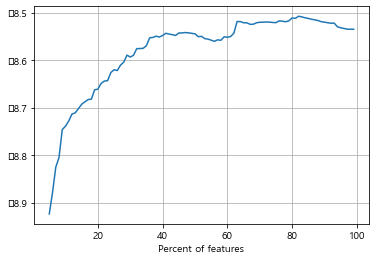

In [191]:
# 사용할 모델 설정 (속도가 빠른 모델 사용 권장)
model = Ridge(random_state=0)

# 각 특성과 타깃(class) 사이에 유의한 통계적 관계가 있는지 계산하여 특성을 선택하는 방법 
cv_scores = []
for p in tqdm(range(5,100,1)):
    X_new = SelectPercentile(percentile=p).fit_transform(X_train_scaled, y_train)    #SelectPercentile: 지정된 비율만큼 특성을 선택한다.
    cv_score = cross_val_score(model, X_new, y_train, scoring='neg_root_mean_squared_error', cv=5).mean()
    cv_scores.append((p,cv_score))

# Print the best percentile
best_score = cv_scores[np.argmax([score for _, score in cv_scores])]
print(best_score)

# Plot the performance change with p
plt.plot([k for k, _ in cv_scores], [score for _, score in cv_scores])
plt.xlabel('Percent of features')
plt.grid()

In [192]:
# 과적합을 피하기 위해 최적의 p값 주변의 값을 선택하는게 더 나은 결과를 얻을 수 있다. 
fs = SelectPercentile(percentile=best_score[0]).fit(X_train_scaled, y_train)
X_train_select = fs.transform(X_train_scaled)
X_test_select = fs.transform(X_test_scaled)

In [194]:
print(X_train_select.shape, X_test_select.shape)
print(X_train_nothuman.columns[fs.get_support()].tolist()) 
#get_support: 선택한 특성을 불린값으로 보여줘서 어떤 특성을 선택했는지 알 수 있다.

(21587, 682) (14380, 682)
['10_stf', '11_stf', '12_stf', '13_stf', '14_stf', '15_stf', '16_stf', '17_stf', '18_stf', '19_stf', 'af_work', 'bf_work', 'datetime', 'floor', 'af_work_rate', 'bf_work_rate', 'af_sales', 'knt_sales', 'mo_sales', 'refund_freq', 'sales_freq', 'all_freq', 'refund_sales_rate', 'refund_all_rate', 'sales_dayofweek', 'sales_freq_mean', 'sales_time_x', 'sales_time_mod_x', 'sales_time_y', 'sales_time_mod_y', 'sales_import', 'import_rate', 'import_refund_rate', 'fall_sales_x', 'spring_sales_x', 'summer_sales_x', 'winter_sales_x', 'fall_sales_y', 'spring_sales_y', 'summer_sales_y', 'winter_sales_y', 'fall_sales', 'spring_sales', 'summer_sales', 'winter_sales', 'sales_spring_rate', 'sales_summer_rate', 'sales_winter_rate', 'refund_spring_rate', 'refund_summer_rate', 'refund_winter_rate', 'all_fall_rate', 'all_spring_rate', 'all_summer_rate', 'wd_sales_rate', 'mon_sale_sm1', 'mon_sale_sm2', 'mon_sale_sm3', 'mon_sale_sm4', 'mon_sale_sm5', 'mon_sale_sm6', 'mon_sale_sm7', 'm

### features 내보내기

In [196]:
pd.DataFrame(X_train_select).to_csv("X_train_select_2nd.csv", index=False)
pd.DataFrame(X_test_select).to_csv("X_test_select_2nd.csv", index=False)